In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')

from utils import scatter_plot, qqplot
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Import Dataset

In [2]:
train = pd.read_csv('./data/thalweg_train_set.csv', converters={'site_no': str}, low_memory=False)
test = pd.read_csv('./data/thalweg_test_set.csv', converters={'site_no': str}, low_memory=False)

In [3]:
X_train = train.drop(columns=['site_no', 'site_tp_cd', 'max_depth_va'])
X_test = test.drop(columns=['site_no', 'site_tp_cd', 'max_depth_va'])

y_train = train[['max_depth_va']]
y_test = test[['max_depth_va']]

In [4]:
X_train['q_va'] = np.log10(X_train['q_va'])
X_train['stream_wdth_va'] = np.log10(X_train['stream_wdth_va'])
X_train['xsec_area_va'] = np.log10(X_train['xsec_area_va'])
X_train['mean_depth_va'] = np.log10(X_train['mean_depth_va'])
y_train= np.log10(y_train)

X_scaler = StandardScaler()
X_train = X_scaler.fit_transform(X_train).astype('float32')

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(np.array(y_train).reshape(-1, 1)).astype('float32').ravel()

X_test['q_va'] = np.log10(X_test['q_va'])
X_test['stream_wdth_va'] = np.log10(X_test['stream_wdth_va'])
X_test['xsec_area_va'] = np.log10(X_test['xsec_area_va'])
X_test['mean_depth_va'] = np.log10(X_test['mean_depth_va'])

X_test = X_scaler.transform(X_test).astype('float32')

In [5]:
from sklearn.model_selection import GroupShuffleSplit, GroupKFold
# splitter = GroupShuffleSplit(test_size=.125, n_splits=4, random_state=7)
splitter = GroupKFold(n_splits=8)

mlp = MLPRegressor(max_iter=1000)
param_grid = {
            'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
            'activation': ['logistic', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive'],
            }

mlp_grid = GridSearchCV(mlp, param_grid, cv=splitter, n_jobs=30, verbose=3)

In [6]:
mlp_grid.fit(X_train, y_train, groups=train['site_no'])

Fitting 8 folds for each of 48 candidates, totalling 384 fits


GridSearchCV(cv=GroupKFold(n_splits=8), estimator=MLPRegressor(max_iter=1000),
             n_jobs=30,
             param_grid={'activation': ['logistic', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             verbose=3)

In [7]:
print(mlp_grid.best_params_)
print(mlp_grid.best_score_)

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'solver': 'adam'}
0.9476916580828494


In [10]:
import pickle

with open('./data/ml_weights/mlp_best_model', "wb") as fp:
    pickle.dump(mlp_grid.best_estimator_, fp)

In [4]:
import pickle

with open('./data/ml_weights/mlp_best_model', "rb") as fp:
    mlp_grid = pickle.load(fp)

In [8]:
y_pred = mlp_grid.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
y_pred = 10 ** y_pred

test size: (8927,), pred size: (8927,)
NSE: 0.9195, R2: 0.9203, PBias: -1.9606, RMSE: 2.1317


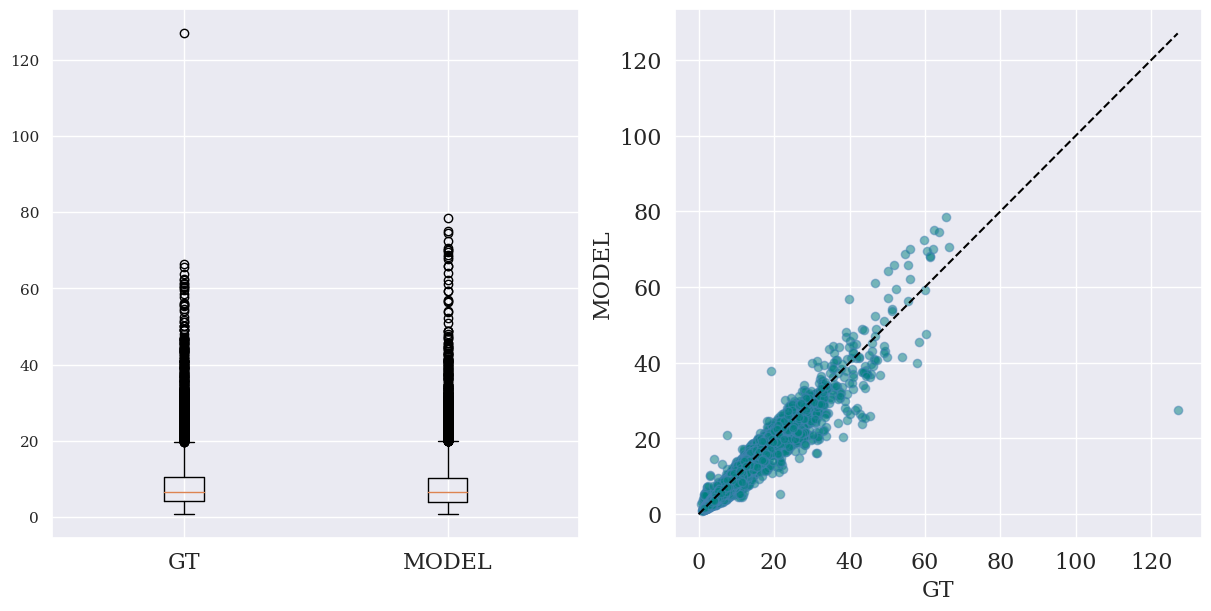

In [9]:
scatter_plot(y_test, y_pred)

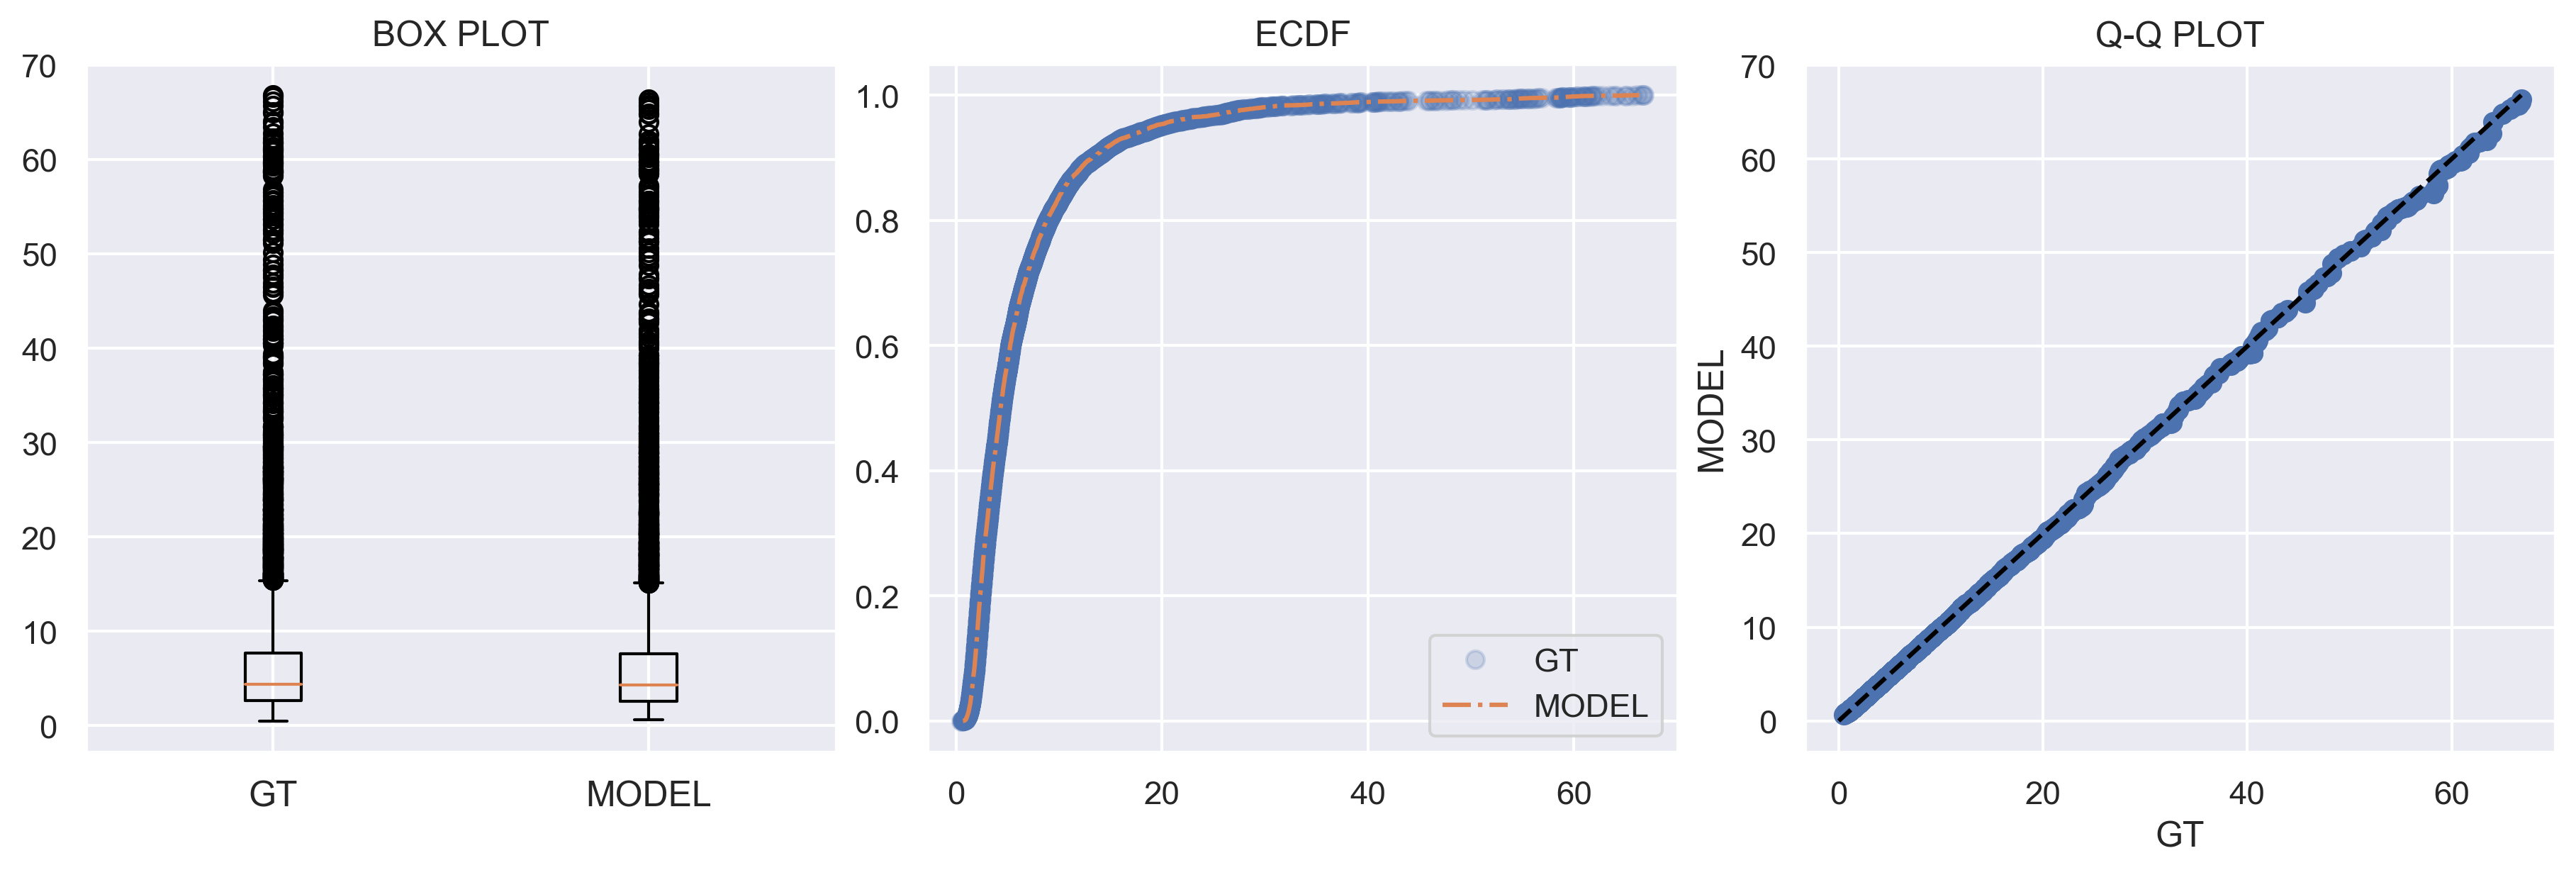

In [15]:
qqplot(y_test.to_numpy().ravel(), y_pred)

In [19]:
train.columns

Index(['site_no', 'site_tp_cd', 'q_va', 'stream_wdth_va', 'xsec_area_va',
       'mean_depth_va', 'max_depth_va'],
      dtype='object')

In [20]:
from sklearn.inspection import permutation_importance
import time

start_time = time.time()
result = permutation_importance(mlp_grid, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

index=['q_va', 'stream_wdth_va', 'xsec_area_va', 'mean_vel_va']
mlp_importances = pd.Series(result.importances_mean, index=index)

Elapsed time to compute the importances: 0.340 seconds


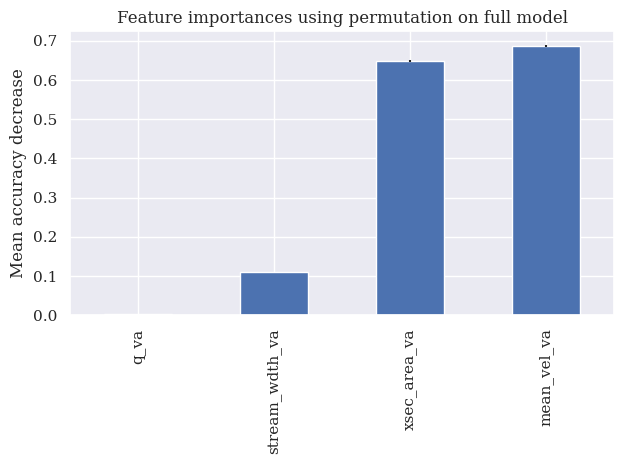

In [21]:
fig, ax = plt.subplots()
mlp_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

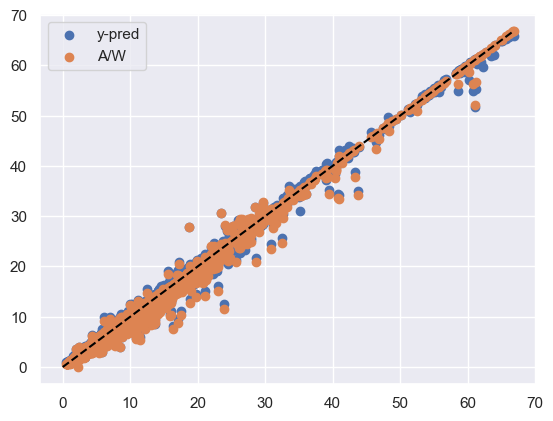

In [18]:
fig, ax = plt.subplots()

max_value = np.max((test['mean_depth_va'].to_numpy().ravel(), test['xsec_area_va'].to_numpy().ravel() / test['stream_wdth_va'].to_numpy().ravel(), y_pred))
ax.scatter(test['mean_depth_va'].to_numpy().ravel(), y_pred, label='y-pred')
ax.scatter(test['mean_depth_va'].to_numpy().ravel(), test['xsec_area_va'].to_numpy().ravel() / test['stream_wdth_va'].to_numpy().ravel(), label='A/W')
ax.plot([0, max_value], [0, max_value], '--', color = 'black', linewidth=1.5)

plt.legend()
plt.show()

NSE: 0.9914, R2: 0.9925, PBias: -3.4322, MSE: 0.7007


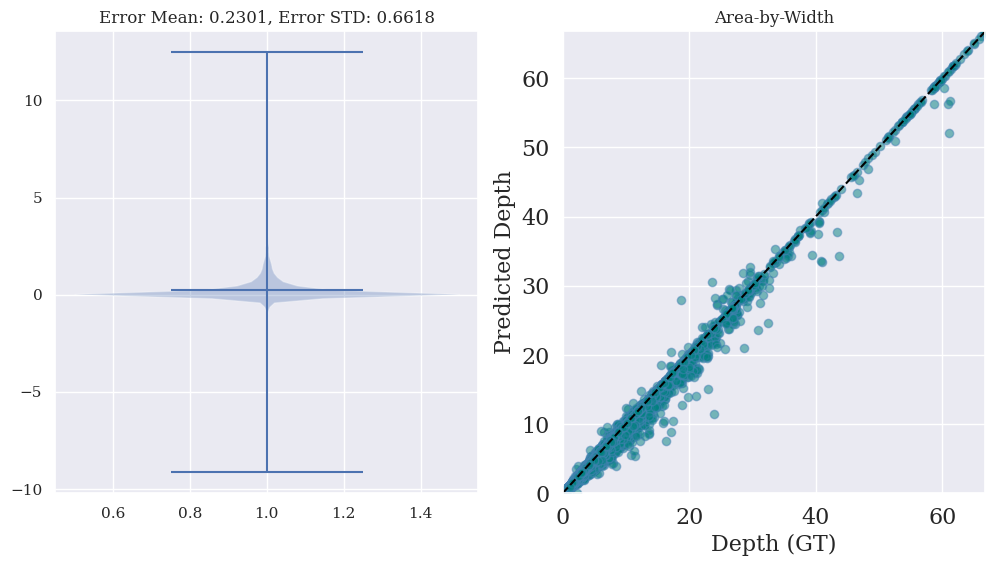

In [19]:
scatter_plot(test['mean_depth_va'], test['xsec_area_va'].to_numpy().ravel() / test['stream_wdth_va'].to_numpy().ravel(), model_name='Area-by-Width')